Тебе надо реализовать алгоритм, который строит доверительные множества (верхнее и нижнее), потом ищет клики и накладывает их друг на друга.

Главное здесь - построить доверительные множества. Чтобы их построить - тебе надо запрограммировать стат тест на проверку гипотезы о коэффициенте корреляции Кендалла (ну и Пирсона потом). То есть у тебя есть наблюдения за парой акций, тебе надо сделать вывод, больше порога связь или нет. Статистика теста есть в статье. У теста в качестве параметра будет еще уровень значимости альфа.
Как это будет готово, можешь добавлять поправку Бонферрони, по сути это каждый отдельный уровень альфа разделить на количество гипотез.

Разница в верхнем и нижнем доверительном множестве - в знаке внутри теста.

In [ ]:
!git clone https://github.com/antonov1lya/statistical_analysis_library.git

Cloning into 'statistical_analysis_library'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 272 (delta 47), reused 36 (delta 20), pack-reused 171
Receiving objects: 100% (272/272), 144.36 KiB | 3.61 MiB/s, done.
Resolving deltas: 100% (130/130), done.


In [ ]:
from statistical_analysis_library.src.multiple_testing import threshold_graph_p_value, _calc_p_value, bonferroni
from statistical_analysis_library.src.test_statistics import kendall_statistics
from statistical_analysis_library.src.numerical_characteristics import pearson, kendall

In [ ]:
#!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tabulate import tabulate
import scipy
import matplotlib.mlab as mlab
import tqdm

#Statistical calculation
from scipy.stats import norm, shapiro, normaltest, anderson

# For warnings suppression
import warnings
warnings.filterwarnings("ignore")
sns.set_palette(sns.color_palette("pastel"))

## Загрузка данных рынка

In [ ]:
stocks = ['AC.PA', 'AI.PA', 'AIR.PA', 'MT.AS', 'CS.PA', 'BNP.PA', 'EN.PA',
  'CAP.PA', 'CA.PA', 'ACA.PA','BN.PA', 'DSY.PA', 'EDEN.PA', 'ENGI.PA',
 'EL.PA', 'ERF.PA', 'RMS.PA', 'KER.PA', 'OR.PA',  'LR.PA',
  'MC.PA', 'ML.PA', 'ORA.PA',  'RI.PA', 'PUB.PA', 'RNO.PA',
 'SAF.PA', 'SGO.PA', 'SAN.PA', 'SU.PA', 'GLE.PA', 'STLAP.PA', 'STMPA.PA',
 'TEP.PA', 'HO.PA',  'TTE.PA', 'VIE.PA', 'DG.PA', 'VIV.PA', 'WLN.PA' ]
# labels = [word[:-2] for word in stocks]
# #print(labels)
# new_labels =  {i:item for i, item in enumerate(labels)}


2021 год

In [ ]:
market_data_2021_prices = yf.download(stocks,'2021-01-01','2022-01-01')
market_data_2021_prices = market_data_2021_prices['Adj Close']

[*********************100%%**********************]  40 of 40 completed


In [ ]:
market_data_2021_prices.isna().sum()

Ticker
AC.PA       0
ACA.PA      0
AI.PA       0
AIR.PA      0
BN.PA       0
BNP.PA      0
CA.PA       0
CAP.PA      0
CS.PA       0
DG.PA       0
DSY.PA      0
EDEN.PA     0
EL.PA       0
EN.PA       0
ENGI.PA     0
ERF.PA      0
GLE.PA      0
HO.PA       0
KER.PA      0
LR.PA       0
MC.PA       0
ML.PA       0
MT.AS       0
OR.PA       0
ORA.PA      0
PUB.PA      0
RI.PA       0
RMS.PA      0
RNO.PA      0
SAF.PA      0
SAN.PA      0
SGO.PA      0
STLAP.PA    0
STMPA.PA    0
SU.PA       0
TEP.PA      0
TTE.PA      0
VIE.PA      0
VIV.PA      0
WLN.PA      0
dtype: int64

In [ ]:
returns_2021 = pd.DataFrame((np.log(market_data_2021_prices[column]/market_data_2021_prices[column].shift(1)) for column in market_data_2021_prices.columns))

2022 год

In [ ]:
market_data_2022_prices = yf.download(stocks,'2022-01-01','2023-01-01')
market_data_2022_prices = market_data_2022_prices['Adj Close']

[*********************100%%**********************]  40 of 40 completed


In [ ]:
market_data_2022_prices.isna().sum()

Ticker
AC.PA       0
ACA.PA      0
AI.PA       0
AIR.PA      0
BN.PA       0
BNP.PA      0
CA.PA       0
CAP.PA      0
CS.PA       0
DG.PA       0
DSY.PA      0
EDEN.PA     0
EL.PA       0
EN.PA       0
ENGI.PA     0
ERF.PA      0
GLE.PA      0
HO.PA       0
KER.PA      0
LR.PA       0
MC.PA       0
ML.PA       0
MT.AS       0
OR.PA       0
ORA.PA      0
PUB.PA      0
RI.PA       0
RMS.PA      0
RNO.PA      0
SAF.PA      0
SAN.PA      0
SGO.PA      0
STLAP.PA    0
STMPA.PA    0
SU.PA       0
TEP.PA      0
TTE.PA      0
VIE.PA      0
VIV.PA      0
WLN.PA      0
dtype: int64

In [ ]:
returns_2022 = pd.DataFrame((np.log(market_data_2022_prices[column]/market_data_2022_prices[column].shift(1)) for column in market_data_2022_prices.columns))

## Проверка гипотез

2021 год

In [ ]:
returns_2021 = returns_2021.T
returns_2021 = returns_2021.iloc [1: , :]
returns_2021

AC.PA    ACA.PA     AI.PA    AIR.PA     BN.PA    BNP.PA  \
Date                                                                     
2021-01-05  0.002066  0.003419 -0.010684 -0.000668  0.003670 -0.002095   
2021-01-06  0.033821  0.039671  0.002220  0.003778  0.008753  0.053749   
2021-01-07 -0.012381  0.007470  0.007731 -0.006118 -0.015737  0.022272   
2021-01-08  0.010717 -0.007470  0.005850  0.005342 -0.022381 -0.022382   
2021-01-11 -0.020529 -0.013683 -0.006951 -0.003558 -0.006433 -0.006758   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.009165  0.001120  0.012678  0.005892  0.018315  0.010489   
2021-12-28 -0.002459  0.003672  0.007062  0.009568  0.003477  0.007261   
2021-12-29 -0.004583  0.001433 -0.004833 -0.011528  0.000183 -0.001810   
2021-12-30  0.009845  0.002860  0.006135  0.004982  0.003100 -0.000659   
2021-12-31 -0.004559 -0.004294 -0.002345 -0.002844 -0.006027  0.001647   

               CA.PA    CAP.PA     CS.PA     DG.PA  ...    SAN.PA    SGO.PA  \
Date                                                ...                       
2021-01-05  0.035258 -0.013728 -0.000412 -0.017070  ... -0.000127 -0.002609   
2021-01-06  0.021747 -0.012319  0.041830  0.037649  ... -0.006095  0.044213   
2021-01-07  0.005202 -0.012068  0.006151  0.001657  ... -0.010113  0.060154   
2021-01-08 -0.011742  0.027541 -0.000982  0.012688  ...  0.013673  0.023038   
2021-01-11  0.005562 -0.029567 -0.005663 -0.037830  ...  0.005695 -0.012500   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27  0.006371  0.012161  0.008652  0.016347  ...  0.008049  0.012931   
2021-12-28  0.010739  0.006025  0.007248  0.001314  ...  0.003494  0.007292   
2021-12-29  0.002510 -0.006956 -0.002093  0.003277  ... -0.000901  0.006116   
2021-12-30  0.003753  0.003716  0.001142  0.003049  ...  0.003709 -0.006278   
2021-12-31  0.005604 -0.000928 -0.003812  0.010060  ... -0.006190 -0.000969   

            STLAP.PA  STMPA.PA     SU.PA    TEP.PA    TTE.PA    VIE.PA  \
Date                                                                     
2021-01-05  0.000000  0.008783 -0.009490 -0.022724  0.025972 -0.005479   
2021-01-06  0.000000  0.001560  0.027399 -0.039060  0.043011  0.030983   
2021-01-07  0.000000  0.010238  0.020364  0.015061  0.010870  0.015377   
2021-01-08  0.000000  0.018349  0.010615  0.010409  0.000667  0.047950   
2021-01-11  0.000000  0.011450 -0.008247 -0.001110 -0.015323 -0.013730   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.023117  0.009605  0.011778  0.005735  0.004012 -0.004091   
2021-12-28  0.001665  0.002273  0.003818  0.008542  0.006651  0.027067   
2021-12-29 -0.007275 -0.005579 -0.000809  0.016360 -0.011110 -0.010491   
2021-12-30 -0.001917 -0.001257 -0.001156  0.002532  0.003235 -0.004975   
2021-12-31  0.000000 -0.008495 -0.002201 -0.008636 -0.006032  0.005595   

              VIV.PA    WLN.PA  
Date                            
2021-01-05 -0.010308 -0.004735  
2021-01-06  0.015611 -0.007019  
2021-01-07 -0.011398 -0.030135  
2021-01-08 -0.006133  0.009290  
2021-01-11  0.004986 -0.040094  
...              ...       ...  
2021-12-27 -0.004193 -0.012125  
2021-12-28  0.003774  0.005928  
2021-12-29  0.001255 -0.014163  
2021-12-30 -0.000837  0.009567  
2021-12-31 -0.005034  0.003475  

[257 rows x 40 columns]

In [ ]:
returns_2021_array = returns_2021.to_numpy()
returns_2021_array.shape

(257, 40)

2022 год

In [ ]:
returns_2022 = returns_2022.T
returns_2022 = returns_2022.iloc [1: , :]
returns_2022_array = returns_2022.to_numpy()
returns_2022_array.shape

(256, 40)

Чем ниже значение p, тем более неожиданными являются доказательства, тем более нелепой выглядит наша нулевая гипотеза.

И что мы делаем, когда чувствуем себя нелепо с нашей нулевой гипотезой? Мы отвергаем ее и выбираем нашу альтернативную гипотезу.

Если р-значение ниже заданного уровня значимости (люди называют его альфа, я называю это порогом нелепости — не спрашивайте, почему, мне просто легче понять), тогда мы отвергаем нулевую гипотезу.

p_value = np.vectorize(lambda y: 1 - norm.cdf(y))

### Функции

In [ ]:
def threshold_graph_p_value(
    x: np.ndarray, measure: str, threshold: float, model: str = "elliptical", bound: str = 'low'
) -> np.ndarray:
    """
    Calculates p-values for testing N(N-1)/2 hypotheses of the form:
    H_ij: measure of similarity between the i and j component
    of the random vector <= threshold vs K_ij: measure of similarity
    between the i and j component of the random vector > threshold.

    Parameters
    ----------
    x : (n,N) array_like
        Sample of the size n from distribution of the N-dimensional random vector.

    measure: {"pearson", "sign_similarity", "fechner", "kruskal", "kendall", "spearman", "partial"}
        The measure of similarity relative to which the test is performed.

    threshold : float
        The threshold in the interval (0, 1) for sign similarity
        and in the interval (-1, 1) for other measures.

    model : {"gaussian", "elliptical"}
        The model according to which the random vector is distributed.

    Returns
    -------
    p_value : (N,N) ndarray
        Matrix of p-values.

    """
    if bound == 'low':
      p_value = np.vectorize(lambda y: 1 - norm.cdf(y))
    else:
      if bound == 'upper':
        p_value = np.vectorize(lambda y: norm.cdf(y))
    return _calc_p_value(x, measure, threshold, model, p_value)

In [ ]:
def bonferroni(p_value: np.ndarray, a: float, bound: str = 'low') -> np.ndarray:
    """
    Bonferroni procedure for testing M=N(N-1)/2 hypotheses
    with tests of the form:
    1(the hypothesis is rejected) if p_value[i,j]<a_ij,
    0(the hypothesis is accepted) if p_value[i,j]>=a_ij.

    In the Bonferonni procedure a_ij=a/M.
    It is known that for this procedure FWER<=a.

    Parameters
    ----------
    p_value : (N,N) ndarray
        Matrix of p-values.

    a : float
        The boundary of FWER.

    Returns
    -------
    decision_matrix : (N,N) ndarray
        Decision matrix.

    """
    N = p_value.shape[0]
    M = N * (N - 1) / 2
    if bound == 'upper':
      decision = np.vectorize(lambda y: int(y > a / M))
    else:
      if bound == 'low':
        decision = np.vectorize(lambda y: int(y < a / M))
    decision_matrix = decision(p_value)
    for i in range(N):
        decision_matrix[i][i] = 0
    return decision_matrix


In [ ]:
def draw_graph(graph, title):

  nx.draw(graph, pos=nx.circular_layout(graph), node_color='violet', edge_color='darkblue', font_color='black', with_labels=True, node_size=1000 )
  plt.title(title,  fontdict={'fontsize':15}, pad=20)
  plt.show()

In [ ]:
def draw_graph_2(graph, title):
  isolated_nodes = list(nx.isolates(graph))
  print("Isolated nodes:", isolated_nodes)
  graph_isolated = graph
  graph_isolated.remove_nodes_from(isolated_nodes)
  nx.draw(graph, pos=nx.circular_layout(graph_isolated), node_color='violet', edge_color='darkblue', font_color='black', with_labels=True, node_size=1000 )
  plt.title(title,  fontdict={'fontsize':15}, pad=20)
  plt.show()


In [ ]:
def draw_edges( title, reliable_edges  = None, unreliable_edges = None ):
  # unreliable_edges = []
  # for i in range(matrix.shape[0]):
  #   low_incidence_list[i] = []
  #   for j in range(matrix.shape[1]):
  #     if low_decision_matrix[i][j] != 0:
  #       if j > i:
  #         unreliable_edges.append((i,j))
  G = nx.Graph()
  if reliable_edges:
    G.add_edges_from(reliable_edges)
  if unreliable_edges:
    G.add_edges_from(unreliable_edges)
  pos = nx.circular_layout(G)  # Positions for all nodes
   # Create a figure with a white background
  fig, ax = plt.subplots(facecolor='white')

    # Set the axis background color to white (or transparent if desired)
  ax.set_facecolor('white')  # For transparent background, use 'none'

    # Turn off the grid
  plt.grid(False)
  # Draw the nodes
  nx.draw_networkx_nodes(G, pos, node_size=1000,  node_color='violet',)
  # Draw the edges with the specified style
  nx.draw_networkx_edges(G, pos, edgelist=unreliable_edges, style='--',  edge_color='darkblue',)
  nx.draw_networkx_edges(G, pos, edgelist=reliable_edges, style='-', width = 2.5,  edge_color='darkblue',)
  # Draw the labels
  nx.draw_networkx_labels(G, pos, font_color='black')
  # Display the graph
  plt.title(title)
  plt.show()

In [ ]:

def draw_unreliable_graph(G, title, is_reliable):
    isolated_nodes = list(nx.isolates(G))
    print("Isolated nodes:", isolated_nodes)

    # Create a copy of the graph to avoid modifying the original
    graph_isolated = G.copy()

    # Remove isolated nodes from the copy
    graph_isolated.remove_nodes_from(isolated_nodes)

    unreliable_edges = graph_isolated.edges()
    pos = nx.circular_layout(graph_isolated)  # Positions for all nodes

    # Create a figure with a white background
    fig, ax = plt.subplots(facecolor='white')

    # Set the axis background color to white (or transparent if desired)
    ax.set_facecolor('white')  # For transparent background, use 'none'

    # Turn off the grid
    plt.grid(False)

    # Draw the nodes
    nx.draw_networkx_nodes(graph_isolated, pos, node_size=1000, node_color='violet', ax=ax)

    # Draw the edges with the specified style
    if is_reliable:
      nx.draw_networkx_edges(graph_isolated, pos, edgelist=unreliable_edges, style='-', edge_color='darkblue', ax=ax)
    else:
      nx.draw_networkx_edges(graph_isolated, pos, edgelist=unreliable_edges, style='--', edge_color='darkblue', ax=ax)

    # Draw the labels
    nx.draw_networkx_labels(graph_isolated, pos, font_color='black', ax=ax)

    # Display the graph with the specified title
    plt.title(title)
    plt.show()

In [ ]:
sns.set(rc = {'figure.figsize':(9, 7)})

#Кендалл

## Построение множеств

### Нижняя граница

In [ ]:
pi = math.pi
threshold_kendall = 2/pi*np.arcsin(0.4)
threshold_kendall

0.2619797608689093

In [ ]:
np.sin(pi*0.2619/2)

0.39988516843891214

In [ ]:
threshold = 0.262
alpha = 0.10

In [ ]:
def bounds_construction(bound, threshold, alpha,  returns_array, returns_df, year):
  if bound == 'low':
    print('Нижняя граница:')
  else:
    print('Верхняя граница:')
  p_values = threshold_graph_p_value(returns_array, 'kendall', threshold, 'elliptical', bound)
  decision_matrix = bonferroni(p_values, alpha, bound)
  decision_matrix_df = pd.DataFrame(data=decision_matrix, index=returns_df.columns, columns=returns_df.columns)
  sns.heatmap(decision_matrix_df)
  print( 'количество ребер в множестве:', decision_matrix.sum()/2)
  title = bound + ' bound' + ' ' + year + ' , threshold = ' + str(threshold)
  return title, decision_matrix

Нижняя граница:
количество ребер в множестве: 37.0


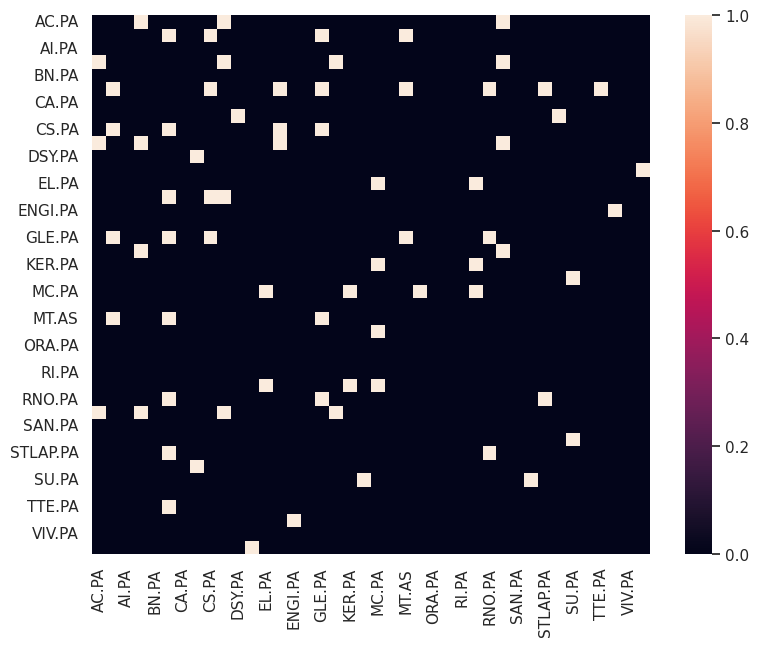

In [ ]:
low_title, low_decision_matrix = bounds_construction('low', threshold, alpha, returns_2021_array, returns_2021, '2021')
low_title = low_title + ', Kendall'

Isolated nodes: [2, 4, 6, 15, 21, 24, 25, 26, 30, 35, 38]


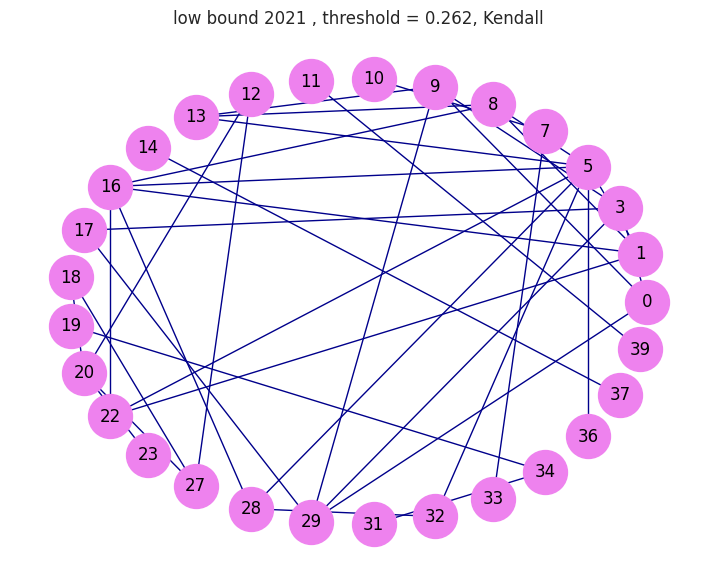

In [ ]:
lower_graph = nx.from_numpy_array(low_decision_matrix)

#draw_unreliable_graph(lower_graph, low_title, 1)

### Истинный граф

Полный истинный граф

In [ ]:
def create_graph_kendall(returns_array, threshold):
    corr_matrix = kendall(returns_array)
    pardalos_matrix = np.where(corr_matrix >= threshold, 1, 0) #retain only values bigger than threshold (make 1), other make 0
    np.fill_diagonal(pardalos_matrix, 0) #fill main diagonal by 0
    print('количество ребер в графе:', pardalos_matrix.sum()/2)
    pardalos_graph = nx.from_numpy_array(pardalos_matrix)
    return pardalos_matrix, pardalos_graph

количество ребер в графе: 189.0
Isolated nodes: [4, 6, 30, 38]


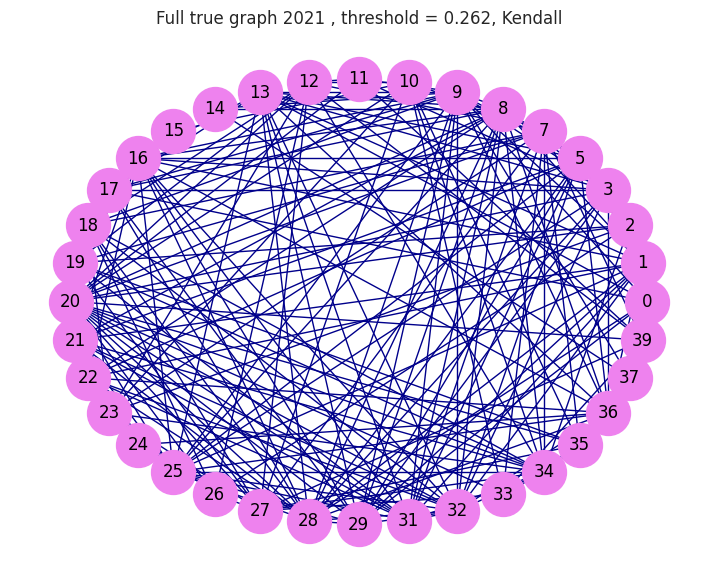

In [ ]:
true_graph_matrix, true_graph = create_graph_kendall(returns_2021_array, threshold)
true_title = 'Full true graph' + low_title[9:]
draw_unreliable_graph(true_graph, true_title, 1)

Истинный граф без ребер из нижнего множества

In [ ]:
low_true_difference = true_graph_matrix - low_decision_matrix
low_true_difference.sum()/2

152.0

In [ ]:
low_true_difference_graph = nx.from_numpy_array(low_true_difference)
low_true_difference_title = 'True graph without low bound edges, ' + low_title[9:]
#draw_graph_2(low_true_difference_graph, low_true_difference_title)

Isolated nodes: [4, 6, 30, 38]


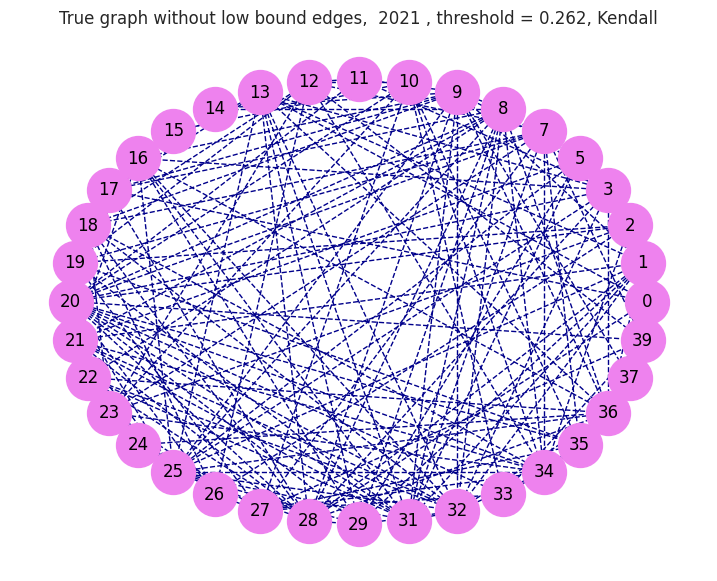

In [ ]:
draw_unreliable_graph(low_true_difference_graph, low_true_difference_title, 0)

### Верхняя граница

Верхняя граница:
количество ребер в множестве: 611.0


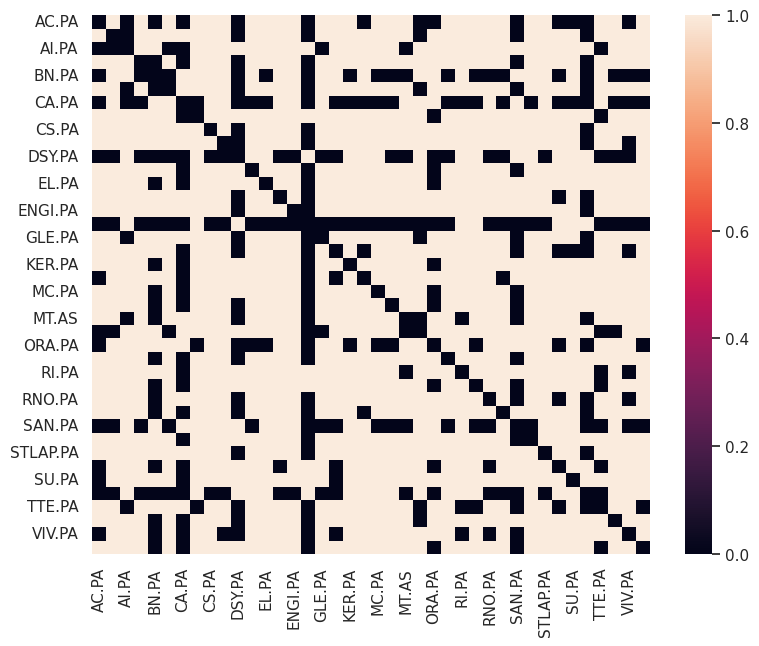

In [ ]:
upper_title, upper_decision_matrix = bounds_construction('upper', threshold, alpha, returns_2021_array, returns_2021, '2021')
upper_title = upper_title + ', Kendall'

In [ ]:
 upper_graph = nx.from_numpy_array(upper_decision_matrix)
# draw_graph_2(upper_graph, upper_title)

Верхняя граница без истинного графа

In [ ]:
upper_true_difference = upper_decision_matrix - true_graph_matrix
upper_true_difference.sum()/2

422.0

In [ ]:
upper_true_difference_graph = nx.from_numpy_array(upper_true_difference)
upper_true_difference_title = 'Upper bound without true graph edges, ' + upper_title[11:]
#draw_graph_2(low_true_difference_graph, low_true_difference_title)

Isolated nodes: []


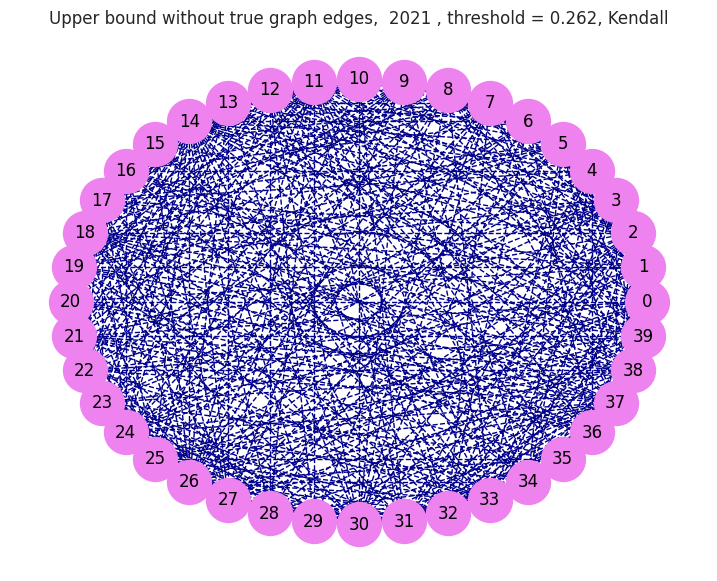

In [ ]:
draw_unreliable_graph(upper_true_difference_graph, upper_true_difference_title, 0)

## Поиск максимальных клик

### Функции

In [ ]:
def find_all_max_cliques(pardalos_graph, flag):
    max_cliques = []
    cliques = nx.find_cliques(pardalos_graph)
    cliques = list(cliques)
    cliques = sorted(cliques, key=len, reverse=True)
    max_cliques.append(cliques[0])
    i = 1
    while len(cliques[i]) == len(cliques[0]):
        max_cliques.append(cliques[i])
        i+=1
    len_of_max_clique = len(max_cliques[0])
    if flag==True:
        print('number of max cliques: ', len(max_cliques))
        print('lenth of max clique =', len_of_max_clique)
        print('maximum clique(s):', max_cliques)
    else:
        print('number of max independent sets: ', len(max_cliques))
        print('lenth of max independent set =', len(max_cliques[0]))
        print('maximum independent sets are: ', max_cliques)
    return max_cliques



def find_max_weight_clique(max_cliques, len_of_max_clique, corr_matrix, flag):
    clique_graph= []
    graph_weights = []
    for i in range(len(max_cliques)):#перебираем все списки вершин для ,макс.клик
        graph_weights.append(0)
        graph = nx.Graph()
        clique_graph.append(graph)
        for j in range(len_of_max_clique):#перебираем все вершины в каждом i-том списке
            for k in range(j+1, len_of_max_clique):
                edge_weight = corr_matrix[max_cliques[i][j]][max_cliques[i][k]]
                graph_weights[i] += edge_weight
                clique_graph[i].add_edge(max_cliques[i][j], max_cliques[i][k], weight = edge_weight)

    print('graph weights:', graph_weights)
    graph_weights_num = list(enumerate(graph_weights, 0))
    if flag == True:
        w_max = max(graph_weights_num, key=lambda i : i[1])
        print('index of clique with max weight is: ', w_max[0])
        print('maximum clique with maximum weight:', max_cliques[w_max[0]])
        return clique_graph[w_max[0]];
    if flag == False:
        w_min = min(graph_weights_num, key=lambda i : i[1])
        print('index of max independent set with min weight is: ', w_min[0])
        print('maximum independent set with minimum weight:', max_cliques[w_min[0]])
        return clique_graph[w_min[0]];

In [ ]:
#найти все клики размера k
def find_cliques_size_k(G, k):
    all_cliques = set()
    for clique in nx.find_cliques(G):
        if len(clique) == k:
            all_cliques.add(tuple(sorted(clique)))
        elif len(clique) > k:
            for mini_clique in itertools.combinations(clique, k):
                all_cliques.add(tuple(sorted(mini_clique)))
    return len(all_cliques)

In [ ]:
def find_max_joint_clique(all_edges, all_cliques):
  max_joint_clique_edges = []
  for edge in all_edges:
    for clique in all_cliques:
      if (edge[0] in clique):
        for clique in all_cliques:
          if (edge[1] in clique) and (tuple(edge) not in max_joint_clique_edges):
            max_joint_clique_edges.append(tuple(edge))
  return max_joint_clique_edges

###Нижняя граница

In [ ]:
low_b_cliques = find_all_max_cliques(lower_graph, True)

NameError: name 'lower_graph' is not defined

In [ ]:
original_clique = low_b_cliques[1]

In [ ]:
original_clique

[5, 16, 1, 8]

In [ ]:
#создаем список (словарь) смежности и список всех надежных ребер
full_low_incidence_list = {}
reliable_edges = []
for i in range(low_decision_matrix.shape[0]):
  full_low_incidence_list[i] = []
  for j in range(low_decision_matrix.shape[1]):
    if low_decision_matrix[i][j] != 0:
      full_low_incidence_list[i].append(j)
      if j > i:
        reliable_edges.append((i,j))



In [ ]:
reliable_edges

[(0, 3),
 (0, 9),
 (0, 29),
 (1, 5),
 (1, 8),
 (1, 16),
 (1, 22),
 (3, 9),
 (3, 17),
 (3, 29),
 (5, 8),
 (5, 13),
 (5, 16),
 (5, 22),
 (5, 28),
 (5, 32),
 (5, 36),
 (7, 10),
 (7, 33),
 (8, 13),
 (8, 16),
 (9, 13),
 (9, 29),
 (11, 39),
 (12, 20),
 (12, 27),
 (14, 37),
 (16, 22),
 (16, 28),
 (17, 29),
 (18, 20),
 (18, 27),
 (19, 34),
 (20, 23),
 (20, 27),
 (28, 32),
 (31, 34)]

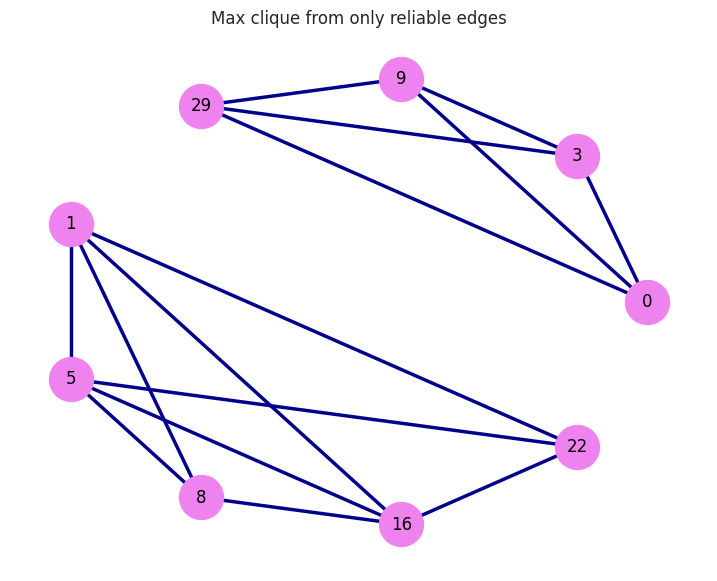

In [ ]:
max_joint_clique_edges = find_max_joint_clique(reliable_edges, low_b_cliques)
draw_edges( 'Max clique from only reliable edges', max_joint_clique_edges)

### Истинный граф

In [ ]:
true_graph_cliques = find_all_max_cliques(true_graph, True)

number of max cliques:  2
lenth of max clique = 11
maximum clique(s): [[1, 32, 5, 8, 16, 25, 28, 3, 9, 13, 36], [1, 32, 5, 8, 16, 25, 28, 3, 9, 13, 29]]


In [ ]:
true_graph_clique_1 = create_clique_from_nodes(true_graph_cliques[0])
true_graph_clique_1_edges = true_graph_clique_1.edges()
rel_edges_true = 0
all_edges = 0
for edge in true_graph_clique_1_edges:
  if edge in reliable_edges:
    rel_edges_true += 1
  all_edges += 1
print ('reliable:', rel_edges_true, 'all:', all_edges)


reliable: 13 all: 55


In [ ]:
true_graph_clique_2 = create_clique_from_nodes(true_graph_cliques[1])
true_graph_clique_2_edges = true_graph_clique_2.edges()
rel_edges_true = 0
all_edges = 0
for edge in true_graph_clique_2_edges:
  if edge in reliable_edges:
    rel_edges_true += 1
  all_edges += 1
print ('reliable:', rel_edges_true, 'all:', all_edges)


reliable: 14 all: 55


In [ ]:
true_incidence_list = {}
true_edges = []
for i in range(true_graph_matrix.shape[0]):
  true_incidence_list[i] = []
  for j in range(true_graph_matrix.shape[1]):
    if true_graph_matrix[i][j] != 0:
      true_incidence_list[i].append(j)
      if j > i:
        true_edges.append((i,j))


In [ ]:
true_max_joint_clique_edges = find_max_joint_clique( true_edges, true_graph_cliques)

In [ ]:
#draw_edges(true_max_joint_clique, 'Max clique from only true edges')

In [ ]:
find_cliques_size_k(true_graph, 4)

836

Создаем структуру клик


In [ ]:
def create_clique_from_nodes(nodes):
  G = nx.Graph()
  G.add_nodes_from(nodes)
  for i in range(len(nodes)):
      for j in range(i + 1, len(nodes)):
          G.add_edge(nodes[i], nodes[j])
  return G

In [ ]:
true_low_diff_clique_edges = []
for edge in true_max_joint_clique_edges:
  if edge not in max_joint_clique_edges:
    true_low_diff_clique_edges.append(edge)


Ищем надежные ребра в этой оставшейся клике:

In [ ]:
reliable_true_low_diff_clique_edges = []
unreliable_true_low_diff_clique_edges = []
for edge in true_low_diff_clique_edges:
  if edge in reliable_edges:
    reliable_true_low_diff_clique_edges.append(edge)
  else:
    unreliable_true_low_diff_clique_edges.append(edge)


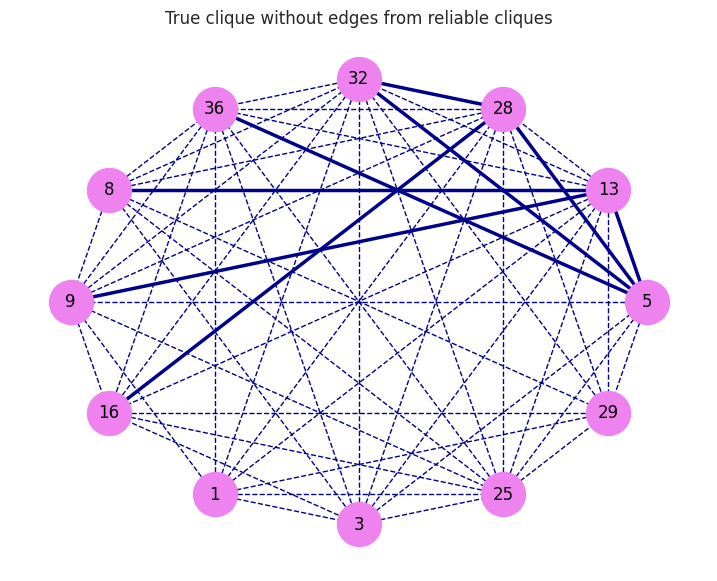

In [ ]:
draw_edges( 'True clique without edges from reliable cliques', reliable_true_low_diff_clique_edges, unreliable_true_low_diff_clique_edges)

### Верхняя граница

In [ ]:
upper_b_cliques = find_all_max_cliques(upper_graph, True)

number of max cliques:  2
lenth of max clique = 25
maximum clique(s): [[7, 11, 31, 12, 18, 20, 27, 39, 21, 25, 3, 8, 14, 32, 37, 1, 5, 16, 9, 13, 28, 26, 29, 0, 17], [7, 11, 31, 12, 18, 20, 27, 39, 21, 25, 3, 8, 14, 32, 37, 1, 5, 16, 9, 13, 28, 22, 29, 0, 17]]


In [ ]:
upper_b_incidence_list = {}
upper_b_edges = []
for i in range(upper_decision_matrix.shape[0]):
  upper_b_incidence_list[i] = []
  for j in range(upper_decision_matrix.shape[1]):
    if upper_decision_matrix[i][j] != 0:
      upper_b_incidence_list[i].append(j)
      if j > i:
        upper_b_edges.append((i,j))


In [ ]:
upper_max_joint_clique_edges = find_max_joint_clique(upper_b_edges, upper_b_cliques)

In [ ]:
upper_true_diff_clique_edges = []
for edge in upper_max_joint_clique_edges:
  if edge not in true_max_joint_clique_edges:
    upper_true_diff_clique_edges.append(edge)

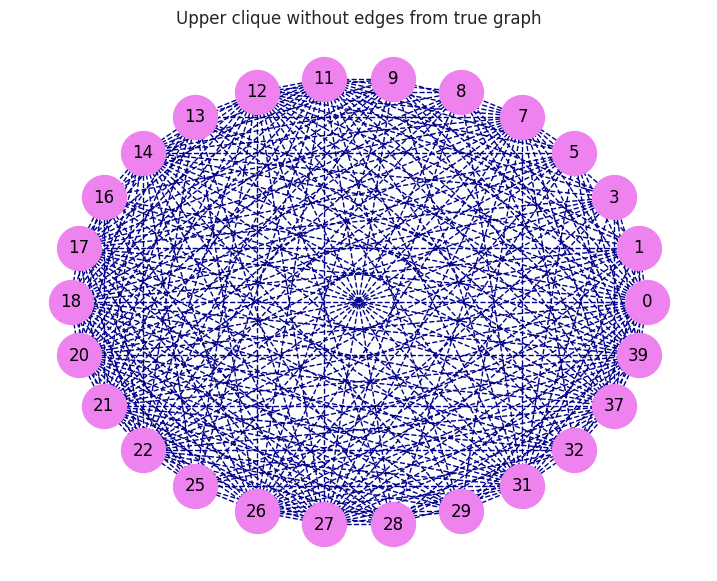

In [ ]:
draw_edges( 'Upper clique without edges from true graph', [], upper_true_diff_clique_edges)

## Построение клики заданной надежности

In [ ]:
current_reliability = 1
given_reliability = 0.1

Клика [0, 9, 3, 29]

In [ ]:
original_clique_1 = low_b_cliques[0]
original_clique_1

[0, 9, 3, 29]

In [ ]:
low_incidence_list_1 = full_low_incidence_list.copy()
#удаляем вершины, которые уже есть в клике
for node in original_clique_1:
  low_incidence_list_1.pop(node)

#сортируем по количеству смежных в нижнем множестве вершин
low_incidence_list_1 = {k:v for k,v in sorted(low_incidence_list_1.items(), key=lambda x:len(x[1]), reverse=True)}

In [ ]:
def calculate_incidence(edge_ends, current_clique):
  counter = 0
  for edge_end in edge_ends:
    for node in current_clique:
      if edge_end == node:
        counter += 1
  return counter


In [ ]:
def calculate_reliability(low_incidence_list, current_clique, curr_all_edges_num, curr_reliable_num):
  max_incidence = 0
  max_inc_key = None
  for key, value in low_incidence_list.items():
    # выбираем такую вершину, для которой число ребер инцидентных с нижним множеством, будет максимальным
    current_incidence = calculate_incidence(value, current_clique)
    if current_incidence > max_incidence:
      max_incidence = current_incidence # максимальное число надежных инцидентных ребер
      max_inc_key = key
  # надежные ребра
  new_reliable_num = curr_reliable_num + max_incidence
  # все ребра из клики размером k+1
  new_all_edges_num = (((len(current_clique) + 1) * (len(current_clique) / 2) ))
  print('Надежных ребер:', new_reliable_num, ', Всего ребер:', new_all_edges_num )
  # надежность
  reliability = new_reliable_num / new_all_edges_num
  #добавляем новую вершину в клику
  return reliability, max_inc_key, new_reliable_num


In [ ]:
def clique_construction(original_low_incidence_list, reliable_edges, given_reliability, original_clique):
  current_reliability = 1
  max_clique = original_clique.copy()
  low_incidence_list = original_low_incidence_list.copy()
  curr_all_edges_num = (len(max_clique)*(len(max_clique) - 1))/2
  curr_unreliable_num = 0
  last_reliability = 1
  curr_reliable_num = curr_all_edges_num
  while current_reliability >= given_reliability:
    current_reliability, new_node, new_reliable_num = calculate_reliability(low_incidence_list, max_clique,
                                                          curr_all_edges_num, curr_reliable_num)
    if current_reliability >= given_reliability:
      curr_reliable_num = new_reliable_num
      max_clique.append(new_node)
      low_incidence_list.pop(new_node)
      last_reliability = current_reliability
      print ('Добавлена вершина', new_node)
      print ('Текущая максимальная клика', max_clique, ' размером', len(max_clique))
      #print ('Надежные ребра ', cur_reliable_edges, ' , Ненадежные ребра ', cur_unreliable_edges)
      print ('Надежность клики:', current_reliability)
      print ('--------------------------------------------------')
  print ('')
  print ('--------------------------------------------------')
  print ('Максимальная клика с надежностью не менее', given_reliability)
  print ('Состав:', max_clique, ', Размер:', len(max_clique))
  print ('Надежность:', last_reliability)
  return max_clique, last_reliability

In [ ]:
final_max_clique, final_reliability = clique_construction(low_incidence_list_1, reliable_edges, given_reliability, original_clique_1)

Надежных ребер: 8.0 , Всего ребер: 10.0
Добавлена вершина 17
Текущая максимальная клика [0, 9, 3, 29, 17]  размером 5
Надежность клики: 0.8
--------------------------------------------------
Надежных ребер: 9.0 , Всего ребер: 15.0
Добавлена вершина 13
Текущая максимальная клика [0, 9, 3, 29, 17, 13]  размером 6
Надежность клики: 0.6
--------------------------------------------------
Надежных ребер: 10.0 , Всего ребер: 21.0
Добавлена вершина 5
Текущая максимальная клика [0, 9, 3, 29, 17, 13, 5]  размером 7
Надежность клики: 0.47619047619047616
--------------------------------------------------
Надежных ребер: 12.0 , Всего ребер: 28.0
Добавлена вершина 8
Текущая максимальная клика [0, 9, 3, 29, 17, 13, 5, 8]  размером 8
Надежность клики: 0.42857142857142855
--------------------------------------------------
Надежных ребер: 14.0 , Всего ребер: 36.0

--------------------------------------------------
Максимальная клика с надежностью не менее 0.4
Состав: [0, 9, 3, 29, 17, 13, 5, 8] , Размер

Клика [5, 16, 1, 8]

In [ ]:
original_clique_2 = low_b_cliques[1]
original_clique_2

[5, 16, 1, 8]

In [ ]:
low_incidence_list_2 = full_low_incidence_list.copy()
#удаляем вершины, которые уже есть в клике
for node in original_clique_2:
  low_incidence_list_2.pop(node)

#сортируем по количеству смежных в нижнем множестве вершин
low_incidence_list_2 = {k:v for k,v in sorted(low_incidence_list_2.items(), key=lambda x:len(x[1]), reverse=True)}

In [ ]:
final_max_clique, final_reliability = clique_construction(low_incidence_list_2, reliable_edges, given_reliability, original_clique_2)

Надежных ребер: 9.0 , Всего ребер: 10.0
Добавлена вершина 22
Текущая максимальная клика [5, 16, 1, 8, 22]  размером 5
Надежность клики: 0.9
--------------------------------------------------
Надежных ребер: 11.0 , Всего ребер: 15.0
Добавлена вершина 13
Текущая максимальная клика [5, 16, 1, 8, 22, 13]  размером 6
Надежность клики: 0.7333333333333333
--------------------------------------------------
Надежных ребер: 13.0 , Всего ребер: 21.0
Добавлена вершина 28
Текущая максимальная клика [5, 16, 1, 8, 22, 13, 28]  размером 7
Надежность клики: 0.6190476190476191
--------------------------------------------------
Надежных ребер: 15.0 , Всего ребер: 28.0
Добавлена вершина 32
Текущая максимальная клика [5, 16, 1, 8, 22, 13, 28, 32]  размером 8
Надежность клики: 0.5357142857142857
--------------------------------------------------
Надежных ребер: 16.0 , Всего ребер: 36.0
Добавлена вершина 9
Текущая максимальная клика [5, 16, 1, 8, 22, 13, 28, 32, 9]  размером 9
Надежность клики: 0.44444444444

KeyError: None

Клика [5, 16, 1, 22]

In [ ]:
original_clique_3 = low_b_cliques[2]
original_clique_3

[5, 16, 1, 22]

In [ ]:
low_incidence_list_3 = full_low_incidence_list.copy()
#удаляем вершины, которые уже есть в клике
for node in original_clique_3:
  low_incidence_list_3.pop(node)

#сортируем по количеству смежных в нижнем множестве вершин
low_incidence_list_3 = {k:v for k,v in sorted(low_incidence_list_3.items(), key=lambda x:len(x[1]), reverse=True)}

In [ ]:
final_max_clique, final_reliability = clique_construction(low_incidence_list_3, reliable_edges, given_reliability, original_clique_3)

Надежных ребер: 9.0 , Всего ребер: 10.0
Добавлена вершина 8
Текущая максимальная клика [5, 16, 1, 22, 8]  размером 5
Надежность клики: 0.9
--------------------------------------------------
Надежных ребер: 11.0 , Всего ребер: 15.0
Добавлена вершина 13
Текущая максимальная клика [5, 16, 1, 22, 8, 13]  размером 6
Надежность клики: 0.7333333333333333
--------------------------------------------------
Надежных ребер: 13.0 , Всего ребер: 21.0
Добавлена вершина 28
Текущая максимальная клика [5, 16, 1, 22, 8, 13, 28]  размером 7
Надежность клики: 0.6190476190476191
--------------------------------------------------
Надежных ребер: 15.0 , Всего ребер: 28.0
Добавлена вершина 32
Текущая максимальная клика [5, 16, 1, 22, 8, 13, 28, 32]  размером 8
Надежность клики: 0.5357142857142857
--------------------------------------------------
Надежных ребер: 16.0 , Всего ребер: 36.0

--------------------------------------------------
Максимальная клика с надежностью не менее 0.5
Состав: [5, 16, 1, 22, 8, 

#Пирсон

In [ ]:
threshold = 0.4
alpha = 0.1

##Построение множеств


### Нижняя граница

In [ ]:
def bounds_construction_pearson(bound, threshold, alpha,  returns_array, returns_df, year):
  if bound == 'low':
    print('Нижняя граница:')
  else:
    print('Верхняя граница:')
  p_values = threshold_graph_p_value(returns_array, 'pearson', threshold, 'gaussian', bound)
  decision_matrix = bonferroni(p_values, alpha, bound)
  decision_matrix_df = pd.DataFrame(data=decision_matrix, index=returns_df.columns, columns=returns_df.columns)
  sns.heatmap(decision_matrix_df)
  print( 'количество ребер в множестве:', decision_matrix.sum()/2)
  title = bound + ' bound' + ' ' + year + ' , threshold = ' + str(threshold)
  return title, decision_matrix

Нижняя граница:
количество ребер в множестве: 36.0


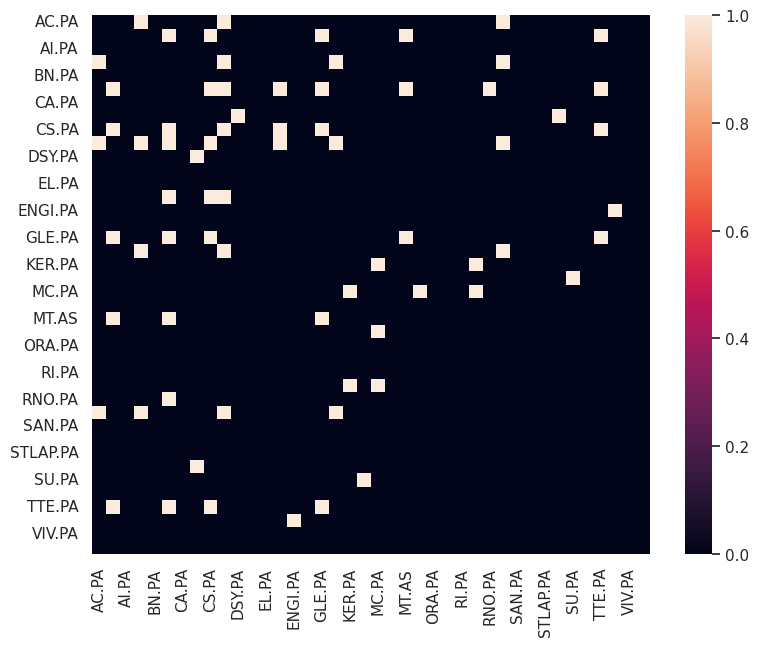

In [ ]:
low_title, low_decision_matrix = bounds_construction_pearson('low', threshold, alpha, returns_2021_array, returns_2021, '2021')
low_title = low_title + ', Pearson'

Isolated nodes: [2, 4, 6, 11, 12, 15, 21, 24, 25, 26, 30, 31, 32, 35, 38, 39]


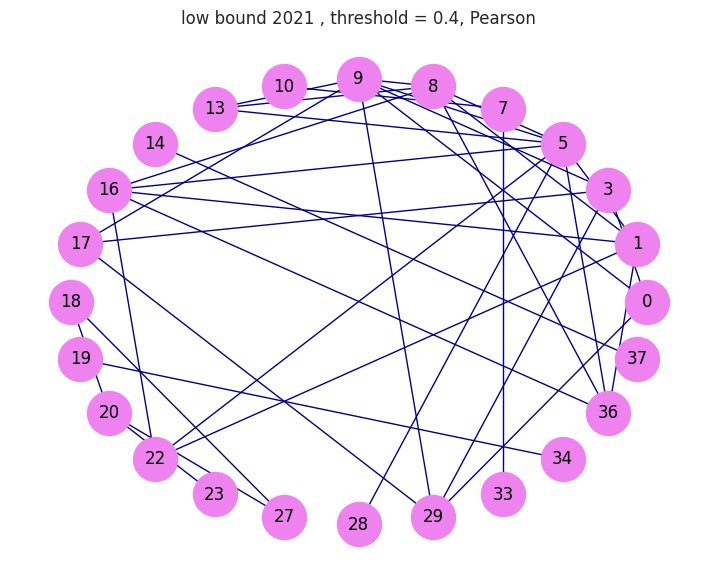

In [ ]:
lower_graph = nx.from_numpy_array(low_decision_matrix)

draw_unreliable_graph(lower_graph, low_title, 1)

### Истинный граф

Полный истинный граф

In [ ]:
def create_graph_pearson(returns_array, threshold):
    corr_matrix = pearson(returns_array)
    pardalos_matrix = np.where(corr_matrix >= threshold, 1, 0) #retain only values bigger than threshold (make 1), other make 0
    np.fill_diagonal(pardalos_matrix, 0) #fill main diagonal by 0
    print('количество ребер в графе:', pardalos_matrix.sum()/2)
    pardalos_graph = nx.from_numpy_array(pardalos_matrix)
    return pardalos_matrix, pardalos_graph

количество ребер в графе: 181.0
Isolated nodes: [4, 6, 30, 32, 38]


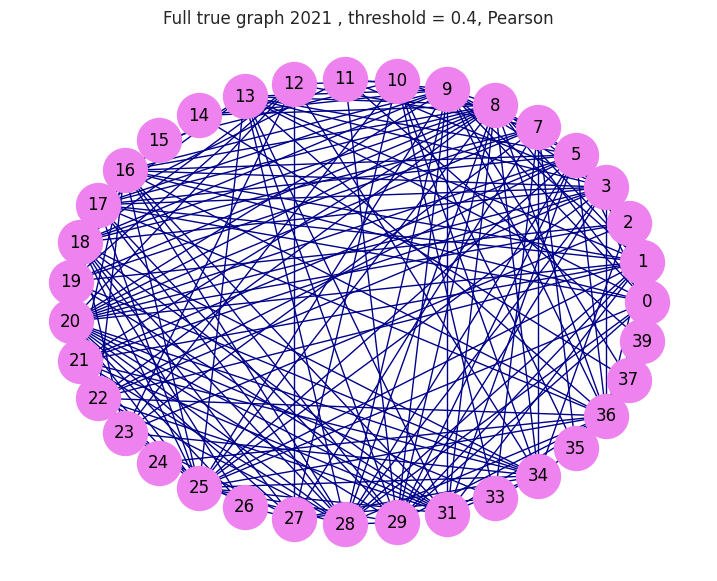

In [ ]:
true_graph_matrix, true_graph = create_graph_pearson(returns_2021_array, threshold)
true_title = 'Full true graph' + low_title[9:]
draw_unreliable_graph(true_graph, true_title, 1)

Истинный граф без ребер из нижнего множества

In [ ]:
low_true_difference = true_graph_matrix - low_decision_matrix
low_true_difference.sum()/2

145.0

In [ ]:
low_true_difference_graph = nx.from_numpy_array(low_true_difference)
low_true_difference_title = 'True graph without low bound edges, ' + low_title[9:]
#draw_graph_2(low_true_difference_graph, low_true_difference_title)

Isolated nodes: [4, 6, 30, 32, 38]


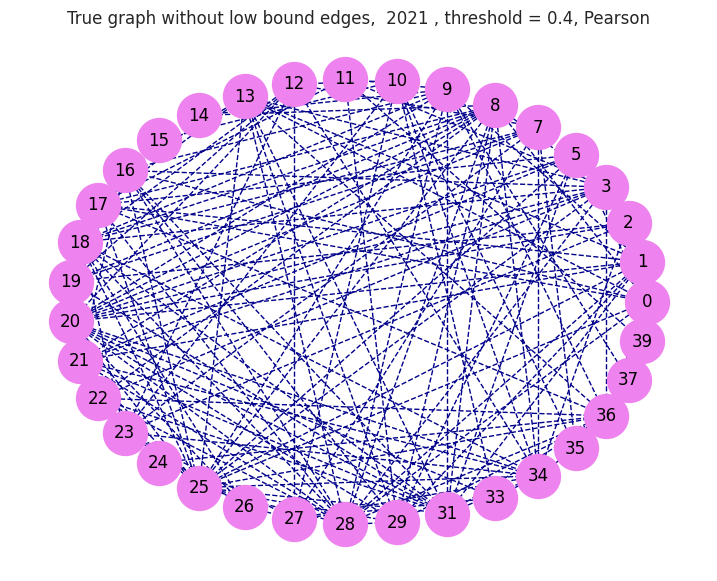

In [ ]:
draw_unreliable_graph(low_true_difference_graph, low_true_difference_title, 0)

### Верхняя граница

Верхняя граница:
количество ребер в множестве: 527.0


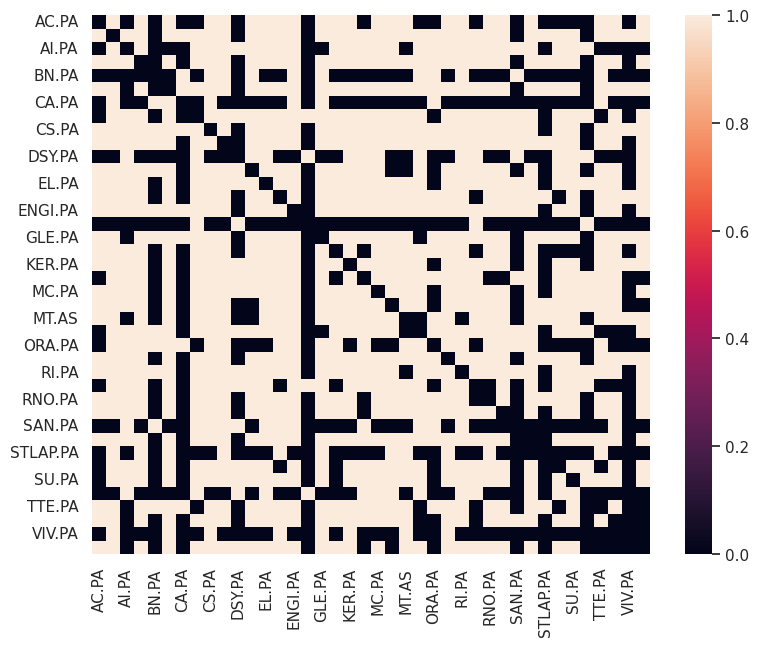

In [ ]:
upper_title, upper_decision_matrix = bounds_construction_pearson('upper', threshold, alpha, returns_2021_array, returns_2021, '2021')
upper_title = upper_title + ', Pearson'

In [ ]:
 upper_graph = nx.from_numpy_array(upper_decision_matrix)
# draw_graph_2(upper_graph, upper_title)

Верхняя граница без истинного графа

In [ ]:
upper_true_difference = upper_decision_matrix - true_graph_matrix
upper_true_difference.sum()/2

346.0

In [ ]:
upper_true_difference_graph = nx.from_numpy_array(upper_true_difference)
upper_true_difference_title = 'Upper bound without true graph edges, ' + upper_title[11:]
#draw_graph_2(low_true_difference_graph, low_true_difference_title)

Isolated nodes: []


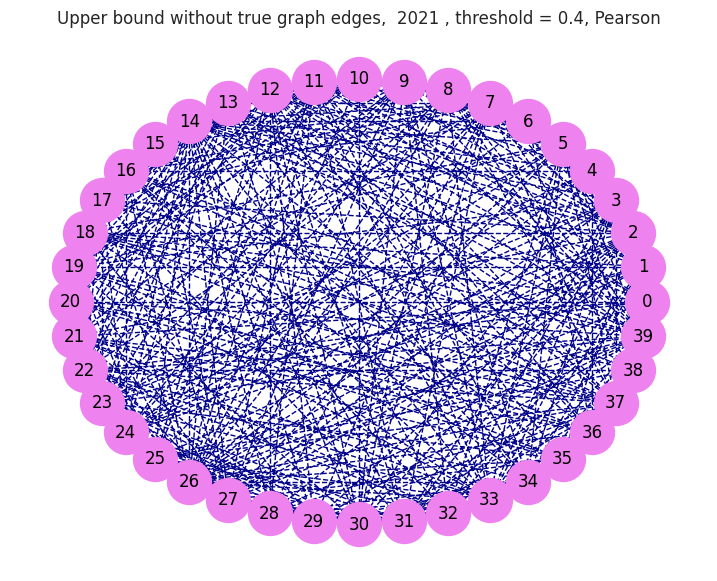

In [ ]:
draw_unreliable_graph(upper_true_difference_graph, upper_true_difference_title, 0)

## Поиск максимальных клик

### Функции

In [ ]:
def find_all_max_cliques(pardalos_graph, flag):
    max_cliques = []
    cliques = nx.find_cliques(pardalos_graph)
    cliques = list(cliques)
    cliques = sorted(cliques, key=len, reverse=True)
    max_cliques.append(cliques[0])
    i = 1
    while len(cliques[i]) == len(cliques[0]):
        max_cliques.append(cliques[i])
        i+=1
    len_of_max_clique = len(max_cliques[0])
    if flag==True:
        print('number of max cliques: ', len(max_cliques))
        print('lenth of max clique =', len_of_max_clique)
        print('maximum clique(s):', max_cliques)
    else:
        print('number of max independent sets: ', len(max_cliques))
        print('lenth of max independent set =', len(max_cliques[0]))
        print('maximum independent sets are: ', max_cliques)
    return max_cliques



def find_max_weight_clique(max_cliques, len_of_max_clique, corr_matrix, flag):
    clique_graph= []
    graph_weights = []
    for i in range(len(max_cliques)):#перебираем все списки вершин для ,макс.клик
        graph_weights.append(0)
        graph = nx.Graph()
        clique_graph.append(graph)
        for j in range(len_of_max_clique):#перебираем все вершины в каждом i-том списке
            for k in range(j+1, len_of_max_clique):
                edge_weight = corr_matrix[max_cliques[i][j]][max_cliques[i][k]]
                graph_weights[i] += edge_weight
                clique_graph[i].add_edge(max_cliques[i][j], max_cliques[i][k], weight = edge_weight)

    print('graph weights:', graph_weights)
    graph_weights_num = list(enumerate(graph_weights, 0))
    if flag == True:
        w_max = max(graph_weights_num, key=lambda i : i[1])
        print('index of clique with max weight is: ', w_max[0])
        print('maximum clique with maximum weight:', max_cliques[w_max[0]])
        return clique_graph[w_max[0]];
    if flag == False:
        w_min = min(graph_weights_num, key=lambda i : i[1])
        print('index of max independent set with min weight is: ', w_min[0])
        print('maximum independent set with minimum weight:', max_cliques[w_min[0]])
        return clique_graph[w_min[0]];

In [ ]:
#найти все клики размера k
def find_cliques_size_k(G, k):
    all_cliques = set()
    for clique in nx.find_cliques(G):
        if len(clique) == k:
            all_cliques.add(tuple(sorted(clique)))
        elif len(clique) > k:
            for mini_clique in itertools.combinations(clique, k):
                all_cliques.add(tuple(sorted(mini_clique)))
    return len(all_cliques)

In [ ]:
def find_max_joint_clique(all_edges, all_cliques):
  max_joint_clique_edges = []
  for edge in all_edges:
    for clique in all_cliques:
      if (edge[0] in clique):
        for clique in all_cliques:
          if (edge[1] in clique) and (tuple(edge) not in max_joint_clique_edges):
            max_joint_clique_edges.append(tuple(edge))
  return max_joint_clique_edges

###Нижняя граница

In [ ]:
low_b_cliques = find_all_max_cliques(lower_graph, True)

number of max cliques:  1
lenth of max clique = 5
maximum clique(s): [[5, 8, 1, 16, 36]]


In [ ]:
original_clique = low_b_cliques[0]

In [ ]:
original_clique

[5, 8, 1, 16, 36]

In [ ]:
#создаем список (словарь) смежности и список всех надежных ребер
full_low_incidence_list = {}
reliable_edges = []
for i in range(low_decision_matrix.shape[0]):
  full_low_incidence_list[i] = []
  for j in range(low_decision_matrix.shape[1]):
    if low_decision_matrix[i][j] != 0:
      full_low_incidence_list[i].append(j)
      if j > i:
        reliable_edges.append((i,j))



In [ ]:
reliable_edges

[(0, 3),
 (0, 9),
 (0, 29),
 (1, 5),
 (1, 8),
 (1, 16),
 (1, 22),
 (1, 36),
 (3, 9),
 (3, 17),
 (3, 29),
 (5, 8),
 (5, 9),
 (5, 13),
 (5, 16),
 (5, 22),
 (5, 28),
 (5, 36),
 (7, 10),
 (7, 33),
 (8, 9),
 (8, 13),
 (8, 16),
 (8, 36),
 (9, 13),
 (9, 17),
 (9, 29),
 (14, 37),
 (16, 22),
 (16, 36),
 (17, 29),
 (18, 20),
 (18, 27),
 (19, 34),
 (20, 23),
 (20, 27)]

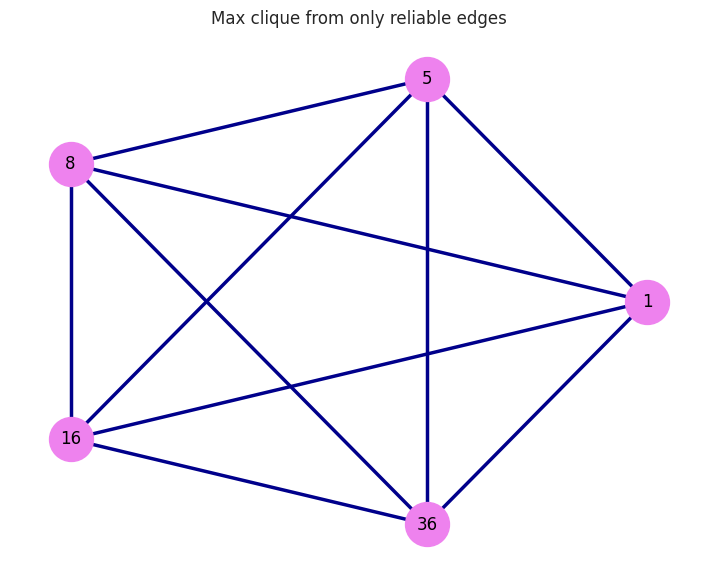

In [ ]:
max_joint_clique_edges = find_max_joint_clique(reliable_edges, low_b_cliques)
draw_edges( 'Max clique from only reliable edges', max_joint_clique_edges)

### Истинный граф

In [ ]:
true_graph_cliques = find_all_max_cliques(true_graph, True)

number of max cliques:  2
lenth of max clique = 12
maximum clique(s): [[8, 25, 3, 28, 5, 0, 36, 9, 16, 17, 29, 13], [8, 25, 3, 28, 5, 1, 16, 36, 9, 17, 13, 29]]


In [ ]:
true_graph_clique_1 = create_clique_from_nodes(true_graph_cliques[0])
true_graph_clique_1_edges = true_graph_clique_1.edges()
rel_edges_true = 0
all_edges = 0
for edge in true_graph_clique_1_edges:
  if edge in reliable_edges:
    rel_edges_true += 1
  all_edges += 1
print ('reliable:', rel_edges_true, 'all:', all_edges)


reliable: 17 all: 66


In [ ]:
true_graph_clique_2 = create_clique_from_nodes(true_graph_cliques[1])
true_graph_clique_2_edges = true_graph_clique_2.edges()
rel_edges_true = 0
all_edges = 0
for edge in true_graph_clique_2_edges:
  if edge in reliable_edges:
    rel_edges_true += 1
  all_edges += 1
print ('reliable:', rel_edges_true, 'all:', all_edges)


reliable: 18 all: 66


In [ ]:
true_incidence_list = {}
true_edges = []
for i in range(true_graph_matrix.shape[0]):
  true_incidence_list[i] = []
  for j in range(true_graph_matrix.shape[1]):
    if true_graph_matrix[i][j] != 0:
      true_incidence_list[i].append(j)
      if j > i:
        true_edges.append((i,j))


In [ ]:
true_max_joint_clique_edges = find_max_joint_clique( true_edges, true_graph_cliques)

In [ ]:
#draw_edges(true_max_joint_clique, 'Max clique from only true edges')

In [ ]:
find_cliques_size_k(true_graph, 5)

1547

Создаем структуру клик


In [ ]:
def create_clique_from_nodes(nodes):
  G = nx.Graph()
  G.add_nodes_from(nodes)
  for i in range(len(nodes)):
      for j in range(i + 1, len(nodes)):
          G.add_edge(nodes[i], nodes[j])
  return G

In [ ]:
true_low_diff_clique_edges = []
for edge in true_max_joint_clique_edges:
  if edge not in max_joint_clique_edges:
    true_low_diff_clique_edges.append(edge)


Ищем надежные ребра в этой оставшейся клике:

In [ ]:
reliable_true_low_diff_clique_edges = []
unreliable_true_low_diff_clique_edges = []
for edge in true_low_diff_clique_edges:
  if edge in reliable_edges:
    reliable_true_low_diff_clique_edges.append(edge)
  else:
    unreliable_true_low_diff_clique_edges.append(edge)


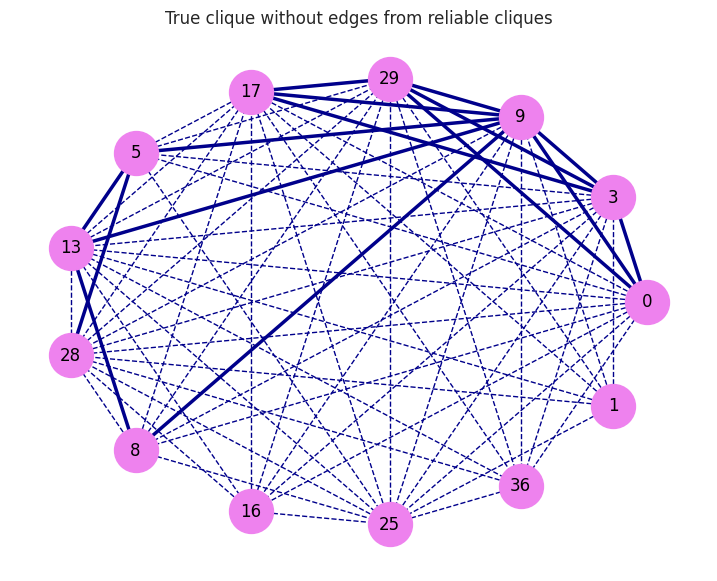

In [ ]:
draw_edges( 'True clique without edges from reliable cliques', reliable_true_low_diff_clique_edges, unreliable_true_low_diff_clique_edges)

### Верхняя граница

In [ ]:
upper_b_cliques = find_all_max_cliques(upper_graph, True)

number of max cliques:  3
lenth of max clique = 21
maximum clique(s): [[8, 14, 9, 26, 1, 3, 25, 31, 5, 12, 18, 20, 11, 16, 29, 28, 37, 13, 36, 0, 17], [8, 14, 9, 26, 1, 3, 25, 31, 5, 12, 18, 20, 21, 16, 37, 13, 36, 28, 29, 0, 17], [8, 14, 9, 22, 1, 3, 5, 16, 25, 31, 12, 18, 20, 21, 37, 13, 36, 28, 29, 0, 17]]


In [ ]:
upper_b_incidence_list = {}
upper_b_edges = []
for i in range(upper_decision_matrix.shape[0]):
  upper_b_incidence_list[i] = []
  for j in range(upper_decision_matrix.shape[1]):
    if upper_decision_matrix[i][j] != 0:
      upper_b_incidence_list[i].append(j)
      if j > i:
        upper_b_edges.append((i,j))


In [ ]:
upper_max_joint_clique_edges = find_max_joint_clique(upper_b_edges, upper_b_cliques)

In [ ]:
upper_true_diff_clique_edges = []
for edge in upper_max_joint_clique_edges:
  if edge not in true_max_joint_clique_edges:
    upper_true_diff_clique_edges.append(edge)

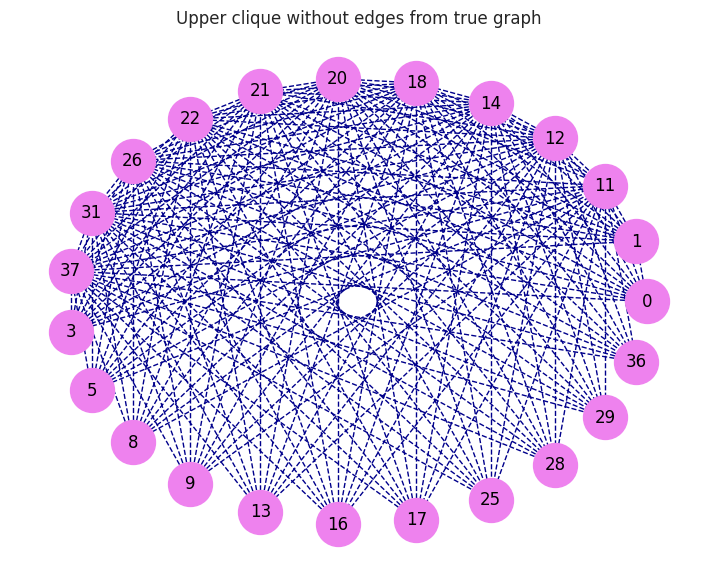

In [ ]:
draw_edges( 'Upper clique without edges from true graph', [], upper_true_diff_clique_edges)

## Построение клики заданной надежности

In [ ]:
current_reliability = 1
given_reliability = 0.2

Клика [0, 9, 3, 29]

In [ ]:
original_clique_1 = low_b_cliques[0]
original_clique_1

[5, 8, 1, 16, 36]

In [ ]:
low_incidence_list_1 = full_low_incidence_list.copy()
#удаляем вершины, которые уже есть в клике
for node in original_clique_1:
  low_incidence_list_1.pop(node)

#сортируем по количеству смежных в нижнем множестве вершин
low_incidence_list_1 = {k:v for k,v in sorted(low_incidence_list_1.items(), key=lambda x:len(x[1]), reverse=True)}

In [ ]:
def calculate_incidence(edge_ends, current_clique):
  counter = 0
  for edge_end in edge_ends:
    for node in current_clique:
      if edge_end == node:
        counter += 1
  return counter


In [ ]:
def calculate_reliability(low_incidence_list, current_clique, curr_all_edges_num, curr_reliable_num):
  max_incidence = 0
  max_inc_key = None
  for key, value in low_incidence_list.items():
    # выбираем такую вершину, для которой число ребер инцидентных с нижним множеством, будет максимальным
    current_incidence = calculate_incidence(value, current_clique)
    if current_incidence > max_incidence:
      max_incidence = current_incidence # максимальное число надежных инцидентных ребер
      max_inc_key = key
  # надежные ребра
  new_reliable_num = curr_reliable_num + max_incidence
  # все ребра из клики размером k+1
  new_all_edges_num = (((len(current_clique) + 1) * (len(current_clique) / 2) ))
  print('Надежных ребер:', new_reliable_num, ', Всего ребер:', new_all_edges_num )
  # надежность
  reliability = new_reliable_num / new_all_edges_num
  #добавляем новую вершину в клику
  return reliability, max_inc_key, new_reliable_num


In [ ]:
def clique_construction(original_low_incidence_list, reliable_edges, given_reliability, original_clique):
  current_reliability = 1
  max_clique = original_clique.copy()
  low_incidence_list = original_low_incidence_list.copy()
  curr_all_edges_num = (len(max_clique)*(len(max_clique) - 1))/2
  curr_unreliable_num = 0
  last_reliability = 1
  curr_reliable_num = curr_all_edges_num
  while current_reliability >= given_reliability:
    current_reliability, new_node, new_reliable_num = calculate_reliability(low_incidence_list, max_clique,
                                                          curr_all_edges_num, curr_reliable_num)
    if current_reliability >= given_reliability:
      curr_reliable_num = new_reliable_num
      max_clique.append(new_node)
      low_incidence_list.pop(new_node)
      last_reliability = current_reliability
      print ('Добавлена вершина', new_node)
      print ('Текущая максимальная клика', max_clique, ' размером', len(max_clique))
      #print ('Надежные ребра ', cur_reliable_edges, ' , Ненадежные ребра ', cur_unreliable_edges)
      print ('Надежность клики:', current_reliability)
      print ('--------------------------------------------------')
  print ('')
  print ('--------------------------------------------------')
  print ('Максимальная клика с надежностью не менее', given_reliability)
  print ('Состав:', max_clique, ', Размер:', len(max_clique))
  print ('Надежность:', last_reliability)
  return max_clique, last_reliability

In [ ]:
final_max_clique, final_reliability = clique_construction(low_incidence_list_1, reliable_edges, given_reliability, original_clique_1)

Надежных ребер: 13.0 , Всего ребер: 15.0
Добавлена вершина 22
Текущая максимальная клика [5, 8, 1, 16, 36, 22]  размером 6
Надежность клики: 0.8666666666666667
--------------------------------------------------
Надежных ребер: 15.0 , Всего ребер: 21.0
Добавлена вершина 9
Текущая максимальная клика [5, 8, 1, 16, 36, 22, 9]  размером 7
Надежность клики: 0.7142857142857143
--------------------------------------------------
Надежных ребер: 18.0 , Всего ребер: 28.0
Добавлена вершина 13
Текущая максимальная клика [5, 8, 1, 16, 36, 22, 9, 13]  размером 8
Надежность клики: 0.6428571428571429
--------------------------------------------------
Надежных ребер: 19.0 , Всего ребер: 36.0
Добавлена вершина 3
Текущая максимальная клика [5, 8, 1, 16, 36, 22, 9, 13, 3]  размером 9
Надежность клики: 0.5277777777777778
--------------------------------------------------
Надежных ребер: 21.0 , Всего ребер: 45.0
Добавлена вершина 29
Текущая максимальная клика [5, 8, 1, 16, 36, 22, 9, 13, 3, 29]  размером 10


KeyError: None

# Исследование динамики рынка

##Кендалл

In [ ]:
threshold_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
low_clique_length_kendall = []
upper_clique_length_kendall = []
true_length_kendall = []
alpha = 0.10

###Нижняя граница

Нижняя граница:
количество ребер в множестве: 330.0
number of max cliques:  7
lenth of max clique = 14
maximum clique(s): [[36, 1, 5, 8, 9, 13, 16, 32, 3, 25, 28, 17, 29, 0], [36, 1, 5, 8, 9, 13, 16, 32, 3, 25, 28, 17, 29, 31], [20, 0, 32, 3, 9, 17, 25, 5, 8, 13, 28, 29, 16, 1], [20, 17, 31, 32, 1, 3, 5, 8, 9, 13, 16, 25, 28, 29], [20, 18, 32, 25, 3, 9, 5, 8, 13, 28, 1, 16, 31, 29], [20, 18, 32, 25, 3, 9, 5, 8, 13, 28, 1, 16, 31, 22], [20, 18, 32, 25, 3, 21, 31, 1, 5, 8, 16, 28, 13, 22]]
Нижняя граница:
количество ребер в множестве: 219.0
number of max cliques:  1
lenth of max clique = 12
maximum clique(s): [[8, 25, 32, 28, 1, 5, 16, 36, 3, 9, 13, 29]]
Нижняя граница:
количество ребер в множестве: 140.0
number of max cliques:  6
lenth of max clique = 8
maximum clique(s): [[9, 3, 13, 28, 5, 8, 16, 1], [9, 3, 13, 28, 5, 8, 16, 29], [9, 36, 1, 5, 8, 16, 28, 13], [25, 5, 8, 16, 32, 1, 3, 28], [32, 1, 5, 8, 13, 16, 28, 3], [32, 1, 5, 8, 13, 16, 28, 36]]
Нижняя граница:
количество ребер в мн

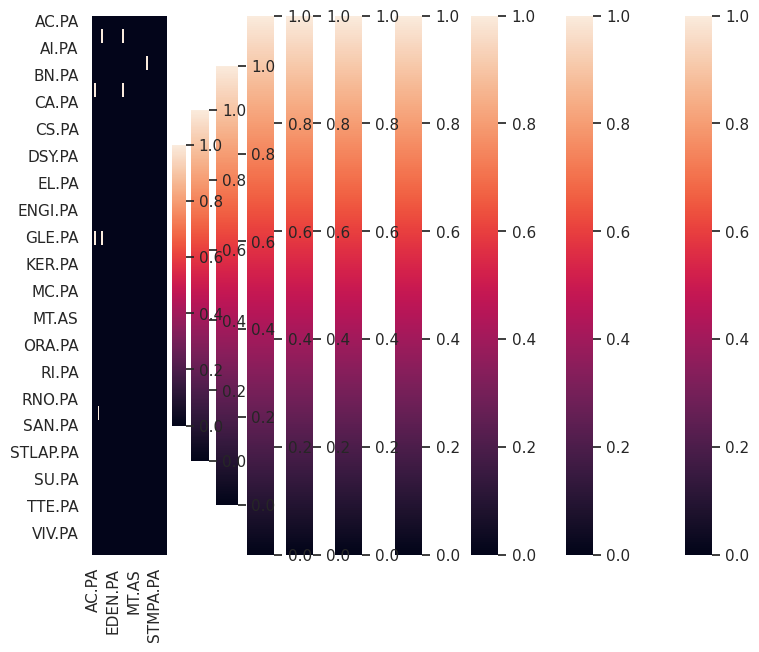

In [ ]:
for threshold in threshold_list:
  low_title, low_decision_matrix = bounds_construction('low', threshold, alpha, returns_2021_array, returns_2021, '2021')
  lower_graph = nx.from_numpy_array(low_decision_matrix)
  low_b_cliques = find_all_max_cliques(lower_graph, True)
  low_clique_length_kendall.append(len(low_b_cliques[0]))

In [ ]:
low_clique_length_kendall

[14, 12, 8, 6, 4, 4, 4, 3, 3, 3]

### Истинный граф

In [ ]:
for threshold in threshold_list:
  true_graph_matrix, true_graph = create_graph_kendall(returns_2021_array, threshold)
  true_graph_cliques = find_all_max_cliques(true_graph, True)
  true_length_kendall.append(len(true_graph_cliques[0]))

количество ребер в графе: 696.0
number of max cliques:  4
lenth of max clique = 30
maximum clique(s): [[2, 26, 34, 11, 14, 31, 32, 38, 3, 1, 8, 9, 13, 17, 29, 5, 16, 0, 28, 37, 18, 20, 25, 7, 39, 12, 21, 33, 27, 22], [2, 26, 34, 11, 14, 31, 32, 38, 3, 1, 8, 9, 13, 17, 29, 5, 16, 0, 28, 37, 18, 20, 25, 7, 39, 12, 21, 33, 27, 23], [2, 26, 34, 11, 14, 31, 32, 38, 3, 1, 8, 9, 13, 17, 29, 5, 16, 19, 37, 20, 25, 39, 7, 12, 18, 21, 28, 33, 27, 22], [2, 26, 34, 11, 14, 31, 32, 38, 3, 1, 8, 9, 13, 17, 29, 5, 16, 19, 37, 20, 25, 39, 7, 12, 18, 21, 28, 33, 27, 23]]
количество ребер в графе: 621.0
number of max cliques:  4
lenth of max clique = 25
maximum clique(s): [[7, 11, 12, 18, 27, 20, 31, 39, 21, 25, 3, 8, 14, 32, 1, 17, 9, 13, 28, 29, 0, 37, 16, 5, 26], [7, 11, 12, 18, 27, 20, 31, 39, 21, 25, 3, 8, 14, 32, 1, 17, 9, 13, 28, 29, 0, 37, 16, 5, 22], [7, 11, 12, 18, 27, 20, 31, 39, 21, 25, 3, 8, 14, 32, 1, 34, 5, 37, 16, 9, 13, 28, 0, 29, 26], [7, 11, 12, 18, 27, 20, 31, 39, 21, 25, 3, 8, 14, 3

### Верхняя граница

Верхняя граница:
количество ребер в множестве: 769.0
number of max cliques:  2
lenth of max clique = 38
maximum clique(s): [[2, 3, 4, 7, 9, 11, 12, 14, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 0, 1, 36, 5, 6, 8, 13, 24, 28, 16], [2, 3, 4, 7, 9, 11, 12, 14, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 0, 1, 36, 5, 6, 8, 13, 24, 28, 10]]
Верхняя граница:
количество ребер в множестве: 751.0
number of max cliques:  3
lenth of max clique = 36
maximum clique(s): [[2, 4, 7, 11, 12, 14, 18, 19, 20, 23, 26, 27, 30, 31, 34, 37, 38, 39, 0, 3, 8, 32, 9, 17, 21, 22, 25, 29, 1, 5, 6, 13, 16, 28, 24, 36], [2, 4, 7, 11, 12, 14, 18, 19, 20, 23, 26, 27, 30, 31, 34, 37, 38, 39, 0, 3, 8, 32, 9, 17, 21, 22, 25, 29, 1, 5, 6, 13, 16, 28, 33, 35], [2, 4, 7, 11, 12, 14, 18, 19, 20, 23, 26, 27, 30, 31, 34, 37, 38, 39, 0, 3, 8, 32, 9, 17, 21, 22, 25, 29, 1, 5, 6, 13, 16, 28, 33, 36]]
Верхняя граница:
количество ребер в множестве: 742.0
num

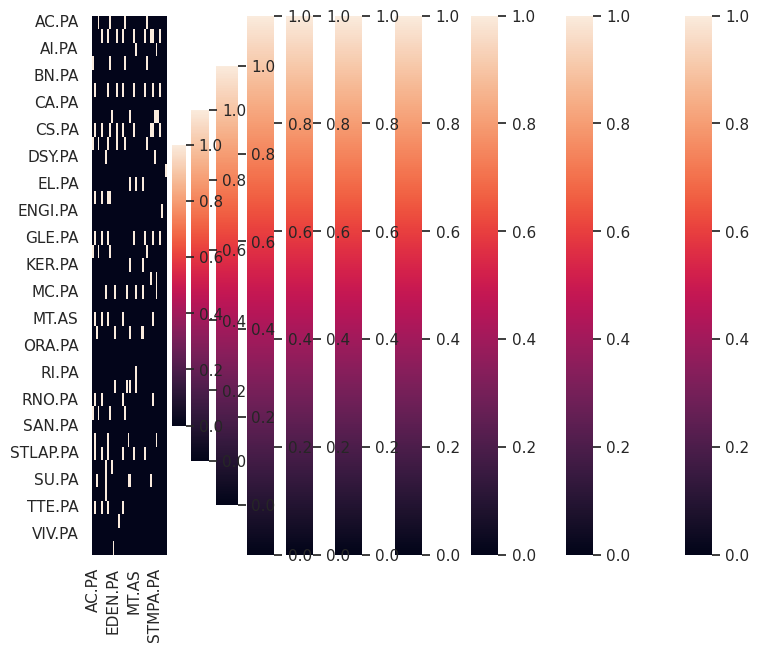

In [ ]:
for threshold in threshold_list:
  upper_title, upper_decision_matrix = bounds_construction('upper', threshold, alpha, returns_2021_array, returns_2021, '2021')
  upper_graph = nx.from_numpy_array(upper_decision_matrix)
  upper_b_cliques = find_all_max_cliques(upper_graph, True)
  upper_clique_length_kendall.append(len(upper_b_cliques[0]))

In [ ]:
upper_clique_length_kendall

[38, 36, 35, 30, 26, 19, 14, 12, 8, 6]

In [ ]:
length_difference_kendall = []
for i in range(len(threshold_list)):
  length_difference_kendall.append(upper_clique_length_kendall[i] - low_clique_length_kendall[i])
length_difference_kendall

[24, 24, 27, 24, 22, 15, 10, 9, 5, 3]

## Пирсон

In [ ]:
threshold_list_pearson = []
for thr in threshold_list:
  threshold_list_pearson.append(np.sin(pi*thr/2))
threshold_list_pearson

[0.07845909572784494,
 0.15643446504023087,
 0.2334453638559054,
 0.3090169943749474,
 0.3826834323650898,
 0.45399049973954675,
 0.5224985647159488,
 0.5877852522924731,
 0.6494480483301837,
 0.7071067811865475]

In [ ]:
low_clique_length_pearson = []
upper_clique_length_pearson = []
true_length_pearson = []
alpha = 0.10

Нижняя граница

Нижняя граница:
количество ребер в множестве: 324.0
number of max cliques:  2
lenth of max clique = 16
maximum clique(s): [[20, 18, 25, 8, 3, 9, 5, 1, 13, 16, 36, 28, 29, 17, 21, 31], [20, 18, 25, 8, 3, 9, 5, 1, 13, 16, 36, 28, 29, 22, 21, 31]]
Нижняя граница:
количество ребер в множестве: 220.0
number of max cliques:  1
lenth of max clique = 13
maximum clique(s): [[0, 1, 3, 36, 5, 8, 9, 13, 16, 17, 25, 28, 29]]
Нижняя граница:
количество ребер в множестве: 142.0
number of max cliques:  1
lenth of max clique = 11
maximum clique(s): [[9, 3, 28, 29, 36, 5, 13, 1, 8, 16, 25]]
Нижняя граница:
количество ребер в множестве: 84.0
number of max cliques:  5
lenth of max clique = 6
maximum clique(s): [[5, 8, 1, 16, 36, 9], [5, 8, 1, 16, 36, 22], [5, 8, 1, 16, 13, 9], [5, 8, 3, 9, 13, 16], [5, 8, 3, 9, 13, 29]]
Нижняя граница:
количество ребер в множестве: 41.0
number of max cliques:  2
lenth of max clique = 5
maximum clique(s): [[0, 9, 17, 3, 29], [5, 1, 8, 16, 36]]
Нижняя граница:
количество ре

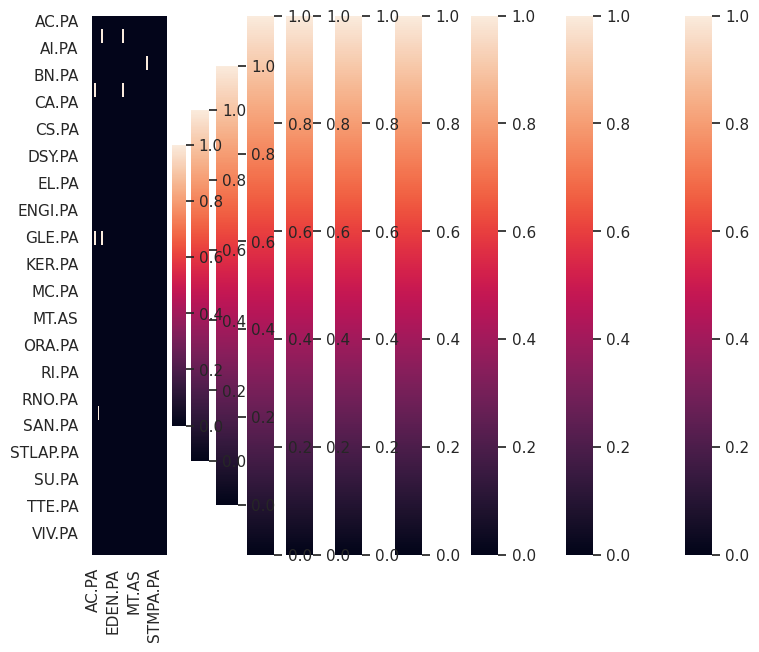

In [ ]:
for threshold in threshold_list_pearson:
  low_title, low_decision_matrix = bounds_construction_pearson('low', threshold, alpha, returns_2021_array, returns_2021, '2021')
  lower_graph = nx.from_numpy_array(low_decision_matrix)
  low_b_cliques = find_all_max_cliques(lower_graph, True)
  low_clique_length_pearson.append(len(low_b_cliques[0]))

In [ ]:
low_clique_length_pearson

[16, 13, 11, 6, 5, 4, 4, 3, 3, 3]

### Истинный граф

In [ ]:
for threshold in threshold_list_pearson:
  true_graph_matrix, true_graph = create_graph_pearson(returns_2021_array, threshold)
  true_graph_cliques = find_all_max_cliques(true_graph, True)
  true_length_pearson.append(len(true_graph_cliques[0]))

количество ребер в графе: 682.0
number of max cliques:  4
lenth of max clique = 29
maximum clique(s): [[2, 11, 31, 3, 14, 29, 1, 5, 8, 9, 13, 17, 22, 25, 12, 18, 20, 34, 33, 7, 39, 37, 23, 26, 27, 28, 16, 21, 0], [2, 11, 31, 3, 14, 29, 1, 5, 8, 9, 13, 17, 22, 25, 12, 18, 20, 34, 33, 7, 39, 37, 23, 26, 27, 28, 16, 21, 19], [2, 11, 31, 3, 14, 29, 1, 5, 8, 9, 13, 17, 22, 25, 12, 18, 20, 34, 33, 7, 39, 37, 23, 26, 36, 16, 0, 28, 21], [2, 11, 31, 3, 14, 29, 1, 5, 8, 9, 13, 17, 22, 25, 12, 18, 20, 34, 33, 7, 39, 37, 23, 26, 36, 16, 19, 28, 21]]
количество ребер в графе: 589.0
number of max cliques:  6
lenth of max clique = 25
maximum clique(s): [[8, 1, 16, 5, 9, 3, 18, 20, 25, 29, 31, 11, 21, 12, 34, 37, 14, 7, 39, 33, 17, 26, 2, 23, 27], [8, 1, 16, 5, 9, 3, 18, 20, 25, 29, 31, 11, 21, 12, 34, 37, 14, 7, 39, 33, 17, 26, 2, 23, 28], [8, 1, 16, 5, 9, 3, 18, 20, 25, 29, 31, 11, 21, 12, 34, 37, 14, 7, 39, 33, 19, 2, 26, 23, 27], [8, 1, 16, 5, 9, 3, 18, 20, 25, 29, 31, 11, 21, 12, 34, 37, 14, 7, 

In [ ]:
true_length_pearson

[29, 25, 18, 15, 13, 9, 5, 4, 4, 3]

### Верхняя граница

Верхняя граница:
количество ребер в множестве: 762.0
number of max cliques:  8
lenth of max clique = 36
maximum clique(s): [[2, 4, 7, 11, 12, 14, 18, 19, 20, 22, 23, 25, 26, 27, 30, 31, 33, 34, 37, 38, 39, 0, 1, 3, 5, 8, 9, 13, 16, 17, 21, 28, 29, 32, 24, 10], [2, 4, 7, 11, 12, 14, 18, 19, 20, 22, 23, 25, 26, 27, 30, 31, 33, 34, 37, 38, 39, 0, 1, 3, 5, 8, 9, 13, 16, 17, 21, 28, 29, 32, 24, 36], [2, 4, 7, 11, 12, 14, 18, 19, 20, 22, 23, 25, 26, 27, 30, 31, 33, 34, 37, 38, 39, 0, 1, 3, 5, 8, 9, 13, 16, 17, 21, 28, 29, 32, 35, 10], [2, 4, 7, 11, 12, 14, 18, 19, 20, 22, 23, 25, 26, 27, 30, 31, 33, 34, 37, 38, 39, 0, 1, 3, 5, 8, 9, 13, 16, 17, 21, 28, 29, 32, 35, 36], [2, 4, 7, 11, 12, 14, 18, 19, 20, 22, 23, 25, 26, 27, 30, 31, 33, 34, 37, 38, 39, 0, 1, 3, 5, 8, 9, 13, 16, 17, 21, 28, 29, 6, 24, 10], [2, 4, 7, 11, 12, 14, 18, 19, 20, 22, 23, 25, 26, 27, 30, 31, 33, 34, 37, 38, 39, 0, 1, 3, 5, 8, 9, 13, 16, 17, 21, 28, 29, 6, 24, 36], [2, 4, 7, 11, 12, 14, 18, 19, 20, 22, 23, 25, 26, 27, 30

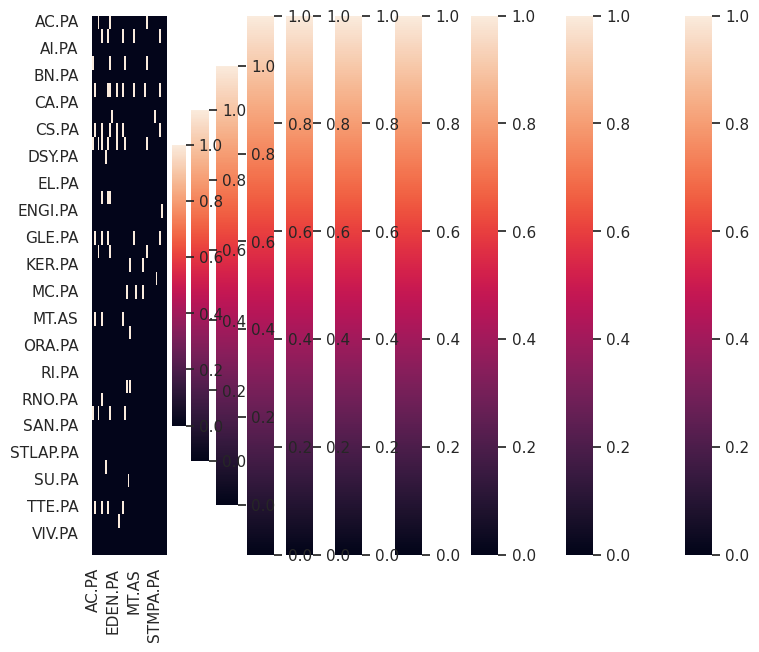

In [ ]:
for threshold in threshold_list_pearson:
  upper_title, upper_decision_matrix = bounds_construction_pearson('upper', threshold, alpha, returns_2021_array, returns_2021, '2021')
  upper_graph = nx.from_numpy_array(upper_decision_matrix)
  upper_b_cliques = find_all_max_cliques(upper_graph, True)
  upper_clique_length_pearson.append(len(upper_b_cliques[0]))

In [ ]:
upper_clique_length_pearson

[36, 36, 34, 29, 23, 17, 13, 11, 6, 5]

In [ ]:
length_difference_pearson = []
for i in range(len(threshold_list)):
  length_difference_pearson.append(upper_clique_length_pearson[i] - low_clique_length_pearson[i])
length_difference_pearson

[20, 23, 23, 23, 18, 13, 9, 8, 3, 2]

In [ ]:
length_difference_kendall

[24, 24, 27, 24, 22, 15, 10, 9, 5, 3]

## Графики

In [ ]:
threshold_list

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

In [ ]:
low_clique_length_kendall

[]

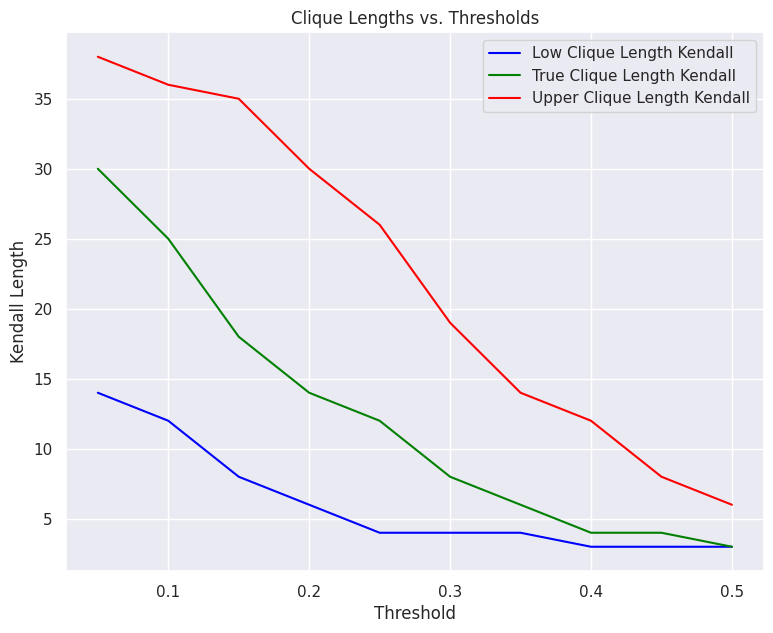

In [ ]:
import matplotlib.pyplot as plt

# Sample data


# Plot each line with a different color
plt.plot(threshold_list, low_clique_length_kendall, label='Low Clique Length Kendall', color='blue')
plt.plot(threshold_list, true_length_kendall, label='True Clique Length Kendall', color='green')
plt.plot(threshold_list, upper_clique_length_kendall, label='Upper Clique Length Kendall', color='red')

# Adding labels and title
plt.xlabel('Threshold')
plt.ylabel('Kendall Length')
plt.title('Clique Lengths vs. Thresholds')

# Adding legend
plt.legend()

# Display the plot
plt.show()

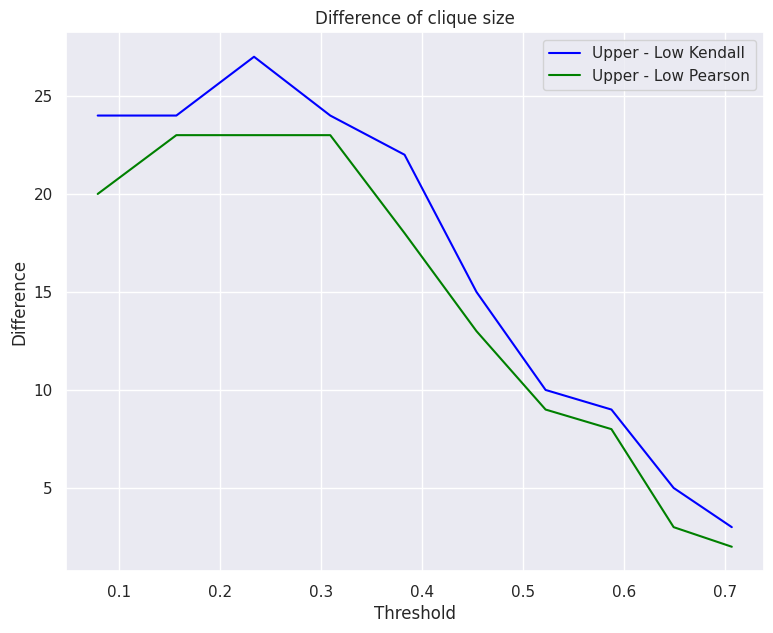

In [ ]:
import matplotlib.pyplot as plt

# Sample data


# Plot each line with a different color
plt.plot(threshold_list_pearson, length_difference_kendall, label='Upper - Low Kendall', color='blue')
plt.plot(threshold_list_pearson, length_difference_pearson, label='Upper - Low Pearson', color='green')

# Adding labels and title
plt.xlabel('Threshold')
plt.ylabel('Difference')
plt.title('Difference of clique size')

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
# Plot each line with a different color
plt.plot(threshold_list, low_clique_length_kendall, label='Low Clique Length Kendall', color='blue')
plt.plot(threshold_list, true_length_kendall, label='True Clique Length Kendall', color='green')
plt.plot(threshold_list, upper_clique_length_kendall, label='Upper Clique Length Kendall', color='red')

# Adding labels and title
plt.xlabel('Threshold')
plt.ylabel('Kendall Length')
plt.title('Clique Lengths vs. Thresholds')

# Adding legend
plt.legend()

# Display the plot
plt.show()